In [1]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [2]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"dionferns","key":"6947fa7c059d67c303a93a6dca576ead"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

In [3]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [5]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [6]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [7]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


# Data Analysis


In [8]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

Train dataset:
  Percentage of NORMAL in train dataset: 27.03%
  Percentage of PNEUMONIA in train dataset: 72.97%
  Proportion of train dataset relative to the total dataset: 79.99%

Val dataset:
  Percentage of NORMAL in val dataset: 27.01%
  Percentage of PNEUMONIA in val dataset: 72.99%
  Proportion of val dataset relative to the total dataset: 9.99%

Test dataset:
  Percentage of NORMAL in test dataset: 27.09%
  Percentage of PNEUMONIA in test dataset: 72.91%
  Proportion of test dataset relative to the total dataset: 10.02%

Label Distribution (Number of Images per Class in Each Split):

Train Split:
  NORMAL: 1266 images
  PNEUMONIA: 3418 images

Val Split:
  NORMAL: 158 images
  PNEUMONIA: 427 images

Test Split:
  NORMAL: 159 images
  PNEUMONIA: 428 images

Brightness Statistics:
  Mean Brightness: 122.79
  Min Brightness: 58.72
  Max Brightness: 221.54


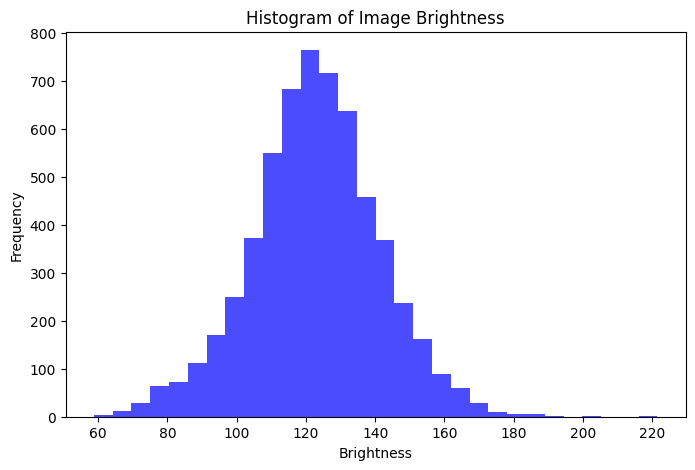

In [9]:
# Function to calculate the percentage of each class in each split and the proportion of each split relative to the total dataset
def calculate_percent_class_split(stats):
    # Calculate the total number of samples across all splits
    total_samples = 0
    for split in stats:
        for cls in stats[split]:
            total_samples += stats[split][cls]

    # Print out percentages for each class within each split
    for split in stats:
        # Calculate the total number of samples in the current split
        total_in_split = sum(stats[split].values())

        print(f"{split.capitalize()} dataset:")

        # Calculate and print the percentage of each class within the current split
        for cls in stats[split]:
            class_prop = stats[split][cls] / total_in_split * 100
            print(f"  Percentage of {cls} in {split} dataset: {class_prop:.2f}%")

        # Calculate and print the proportion of the current split relative to the total dataset
        split_prop = total_in_split / total_samples * 100
        print(f"  Proportion of {split} dataset relative to the total dataset: {split_prop:.2f}%")
        print()

# Call the function to calculate and print the statistics
calculate_percent_class_split(stats)


# Initialize dictionary for label distribution statistics
stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}

# Initialize lists to gather input feature statistics
image_sizes = []
brightness_values = []

# Collect statistics for each split and class
for split in splits:
    for cls in classes:
        # Get path to class folder
        class_path = os.path.join(new_dataset_path, split, cls)
        if os.path.exists(class_path):
            # Count number of images in the class
            num_images = len(os.listdir(class_path))
            stats[split][cls] = num_images

            # Collect input features for each image
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:                   #PIL.Image.open() function to open the image file located at img_path.
                        # Get image size (resolution)
                        image_sizes.append(img.size)                    # retrieves the dimensions (width and height) of the image

                        # Calculate average brightness
                        img_gray = img.convert('L')                     # Convert to grayscale
                        brightness = np.mean(np.array(img_gray))        #np.array(img_gray) converts the grayscale image to a NumPy array, where each pixel’s intensity is represented as a value between 0 (black) and 255 (white).
                                                                        #np.mean() calculates the average brightness of the image by taking the mean of all pixel values in the grayscale array.
                        brightness_values.append(brightness)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Display label distribution statistics
print("Label Distribution (Number of Images per Class in Each Split):")
for split in stats:
    print(f"\n{split.capitalize()} Split:")
    for cls in stats[split]:
        print(f"  {cls}: {stats[split][cls]} images")

# Analyze and display input feature statistics
# 1. Image size (resolution)
unique_sizes = set(image_sizes)

# 2. Average Brightness
print("\nBrightness Statistics:")
print(f"  Mean Brightness: {np.mean(brightness_values):.2f}")
print(f"  Min Brightness: {np.min(brightness_values):.2f}")
print(f"  Max Brightness: {np.max(brightness_values):.2f}")

# Plot histogram for brightness values
plt.figure(figsize=(8, 5))
plt.hist(brightness_values, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Image Brightness')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()



**(a)**

From the above data, it is clear that the dataset has a higher percentage of pneumonia scans than normal scans for training, validation and testing dataset. This could cause the model to be better at identifying the majority class which is the pneumonia scans compared to normal scans, However, the complexity in detecting patterns for pneumonia could conter the imbalace.

Furthermore, with more pneumonia scans, the model may learn to overfit the pneumonia features which will cause the model to underperform in identifying normal scans.

The histogram shows a nearly symmetric distribution of brigtness of the images, the symmetrical shape is ideal for image processing as it shows that the dataset doesn't have a huge lighting bias.

# Data Preparation (5 marks)



In [10]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 32

In [11]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []


        #self.images are list of paths for either of the splits
        #self.labels are labels 1 or 0 for either of the splits

        classes = {'NORMAL': 0,'PNEUMONIA':1 }

        for cls in classes:
            cls_path = os.path.join(root_dir, split, cls)
            for img in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img)
                self.images.append(img_path)
                self.labels.append(classes[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        labels = self.labels[idx]

        img = Image.open(image_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, labels

In [12]:
# Define data transforms
transform_SimpleModel = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [13]:

# Create datasets
train_dataset_SimpleModel = ChestXrayDataset(root_dir=dataset_path, transform=transform_SimpleModel)         #'''check root_dir value is correct from the email.'''
test_dataset_SimpleModel = ChestXrayDataset(root_dir=dataset_path, split='test', transform=transform_SimpleModel)
val_dataset_SimpleModel = ChestXrayDataset(root_dir=dataset_path, split='val', transform=transform_SimpleModel)

# Create data loaders

train_loader_SimpleModel = DataLoader(train_dataset_SimpleModel, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)            #What do these do? num_workers=2, pin_memory=True
test_loader_SimpleModel = DataLoader(test_dataset_SimpleModel, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader_SimpleModel = DataLoader(val_dataset_SimpleModel, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Print dataset sizes

print(f"Training Dataset size: {len(train_dataset_SimpleModel)}")
print(f"Testing Dataset size: {len(test_dataset_SimpleModel)}")
print(f"Validation Dataset size: {len(val_dataset_SimpleModel)}")

print()

print(f"Total number of Training Batches: {len(train_loader_SimpleModel)}")
print(f"Total number of Testing Batches: {len(test_loader_SimpleModel)}")
print(f"Total number of Validation Batches: {len(val_loader_SimpleModel)}")

print()

print(f"Total dataset size: {len(train_dataset_SimpleModel) + len(test_dataset_SimpleModel) + len(val_dataset_SimpleModel)}")
print(f"Batch size: {batch_size}")

print()

# Print batch shapes
sample_data = next(iter(train_loader_SimpleModel))
sample_img, sample_label = sample_data
print(f"Batch shape: Image shape = {sample_img.shape}, label shape = {sample_label.shape}")

Training Dataset size: 4684
Testing Dataset size: 587
Validation Dataset size: 585

Total number of Training Batches: 147
Total number of Testing Batches: 19
Total number of Validation Batches: 19

Total dataset size: 5856
Batch size: 32

Batch shape: Image shape = torch.Size([32, 3, 128, 128]), label shape = torch.Size([32])


**(a)**

_Insert brief discussion of any design choices you made here_

**I have resized the images to 128 by 128 as the images were different shapes and size. I have particulary chosen 128 by 128 by experimenting with 64 X 64 and 256 X 256, which i found computaionaly challenging for the PC i am working on.I have also chosen a batch size of 32 as starting point, which i will experiment with to improve the model further.**


# Training a Baseline




In [14]:
num_epochs = 15
use_wandb = True  # Set to True if you want to use wandb
lr = 0.001

In [15]:
# Define the model
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()


        self.conv_relu_pool_stack = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 20, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2), #

            # Layer 2
            nn.Conv2d(20, 4, 3, 1, 1),
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.out_layer = nn.Linear(64*64*4, 2)

    def forward(self, x):
        x = self.conv_relu_pool_stack(x)
        x = self.flatten(x)
        x = self.out_layer(x)
        return x

In [16]:
def calculate_class_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    final = (predicted == labels).sum().item()
    accuracy = (final / labels.size(0)) * 100
    return accuracy


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=True):

    """
    Train and validate the model for the specified number of epochs.
    """

    # Inner function to initialize wandb config
    def init_wandb_config():
        if use_wandb:
            wandb.init(project='Final Results DL(CW1)', #replace with appropriate project name
                        name='Transform number 65)')  #replace with appropriate run name

        config = {
            "learning_rate": optimizer.param_groups[0]["lr"],
            "architecture": model.__class__.__name__,
            "epochs": num_epochs,
            "weight_decay": optimizer.param_groups[0].get("weight_decay", None),
            "batch_size": getattr(train_loader, 'batch_size', None),
            "shuffle": getattr(train_loader, 'shuffle', None),
            "loss": criterion.__class__.__name__
        }
        if use_wandb:
            wandb.config.update(config)


    # Inner function to train a single epoch
    def train_single_epoch():
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        class_correct = [0, 0]  # To store correct counts for each class
        class_total = [0, 0]  # To store total counts for each class

        for images, labels in tqdm(train_loader, desc="Training Epoch", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Adjust output shape if necessary
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Accumulate metrics
            running_loss += loss.item() * images.size(0)                #the cumulative total loss across all processed batches up to that point
            batch_accuracy = calculate_class_accuracy(outputs, labels)  # accuracy for this batch
            correct_preds += batch_accuracy * labels.size(0) / 100  # total number of correct predictions made across all batches.
            total_preds += labels.size(0)                           #total predictions made till now.

            # Calculate class-specific accuracy
            predictions = (outputs >= 0.5).float()  # Binary threshold at 0.5
            for i in range(len(labels)):
                label = int(labels[i].item())
                pred = int(torch.argmax(predictions[i]).item())
                if pred == label:
                    class_correct[label] += 1
                class_total[label] += 1

        epoch_loss = running_loss / total_preds
        epoch_accuracy = (correct_preds / total_preds) * 100
        class_accuracies = [(class_correct[i] / class_total[i]) * 100 if class_total[i] > 0 else 0 for i in range(2)]
        return epoch_loss, epoch_accuracy, class_accuracies

    # Inner function to validate a single epoch
    def validate_single_epoch():
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0
        val_class_correct = [0, 0]
        val_class_total = [0, 0]

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation Epoch", leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)  # Adjust output shape if necessary

                loss = criterion(outputs, labels.long())

                # Accumulate metrics
                val_running_loss += loss.item() * images.size(0)
                batch_val_accuracy = calculate_class_accuracy(outputs, labels)  # Using the inner function for accuracy
                val_correct_preds += batch_val_accuracy * labels.size(0) / 100
                val_total_preds += labels.size(0)

                # Calculate class-specific accuracy
                predictions = (outputs >= 0.5).float()
                for i in range(len(labels)):
                    label = int(labels[i].item())
                    pred = int(torch.argmax(predictions[i]).item())
                    if pred == label:
                        val_class_correct[label] += 1
                    val_class_total[label] += 1

        val_epoch_loss = val_running_loss / val_total_preds
        val_epoch_accuracy = (val_correct_preds / val_total_preds) * 100
        val_class_accuracies = [(val_class_correct[i] / val_class_total[i]) * 100 if val_class_total[i] > 0 else 0 for i in range(2)]
        return val_epoch_loss, val_epoch_accuracy, val_class_accuracies

    # Inner function to log metrics to wandb
    def log_metrics_wandb(epoch, train_loss, train_acc, val_loss, val_acc,train_class_acc, val_class_acc, learning_rate):
        if use_wandb:
            wandb.log({
                "Epoch": epoch + 1,
                "Train Loss": train_loss,
                "Train Accuracy": train_acc,
                "Validation Loss": val_loss,
                "Validation Accuracy": val_acc,
                "Training Class Accuracy/Normal": train_class_acc[0],  # Log training class accuracy
                "Training Class Accuracy/Pneumonia": train_class_acc[1],
                "Validation Class Accuracy/Normal": val_class_acc[0],
                "Validation Class Accuracy/Pneumonia": val_class_acc[1],
                "Learning Rate": learning_rate

            })

    # Start of train_model function
    model.to(device)
    init_wandb_config()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_accuracy, train_class_accuracy = train_single_epoch()
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_class_accuracies.append(train_class_accuracy)

        # Validation phase
        val_loss, val_accuracy, val_class_accuracy = validate_single_epoch()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(val_class_accuracy)

        current_learning_rate = optimizer.param_groups[0]['lr']

        # Log metrics with wandb if enabled
        log_metrics_wandb(epoch, train_loss, train_accuracy, val_loss, val_accuracy, train_class_accuracy, val_class_accuracy, current_learning_rate)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


    if use_wandb:
        wandb.finish()

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [18]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

    # Plot training and validation loss
    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Figure 1: Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Figure 2: Training and Validation Accuracy')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


    if train_class_accuracies and val_class_accuracies:
        plt.figure(figsize=(14, 5))

        # Extract values for each class from training and validation accuracies
        train_class1_accuracies = [acc[0] for acc in train_class_accuracies]  # Class 1 in training
        train_class2_accuracies = [acc[1] for acc in train_class_accuracies]  # Class 2 in training

        val_class1_accuracies = [acc[0] for acc in val_class_accuracies]      # Class 1 in validation
        val_class2_accuracies = [acc[1] for acc in val_class_accuracies]      # Class 2 in validation

        # Training Class Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(train_class1_accuracies, label='Normal Accuracy')
        plt.plot(train_class2_accuracies, label='Pneumonia Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Class Accuracy (%)')
        plt.title('Figure 3: Training Class Accuracy Over Epochs')
        plt.legend()

        # Validation Class Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(val_class1_accuracies, label='Normal Accuracy')
        plt.plot(val_class2_accuracies, label='Pneumonia Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Class Accuracy (%)')
        plt.title('Figure 4: Validation Class Accuracy Over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

wandb: Currently logged in as: dionfernandes5 (dionfernandes5-university-college-london-ucl-). Use `wandb login --relogin` to force relogin


Epoch [1/15], Train Loss: 0.6117, Train Acc: 72.03%, Val Loss: 0.5724, Val Acc: 72.99%


Epoch [2/15], Train Loss: 0.5606, Train Acc: 72.97%, Val Loss: 0.5338, Val Acc: 72.99%


Epoch [3/15], Train Loss: 0.4927, Train Acc: 73.93%, Val Loss: 0.4251, Val Acc: 77.09%


Epoch [4/15], Train Loss: 0.3692, Train Acc: 84.80%, Val Loss: 0.3047, Val Acc: 87.01%


Epoch [5/15], Train Loss: 0.2862, Train Acc: 88.66%, Val Loss: 0.2414, Val Acc: 91.11%


Epoch [6/15], Train Loss: 0.2498, Train Acc: 90.12%, Val Loss: 0.2184, Val Acc: 92.82%


Epoch [7/15], Train Loss: 0.2351, Train Acc: 90.31%, Val Loss: 0.2254, Val Acc: 88.89%


Epoch [8/15], Train Loss: 0.2181, Train Acc: 91.12%, Val Loss: 0.1770, Val Acc: 91.79%


Epoch [9/15], Train Loss: 0.2170, Train Acc: 91.48%, Val Loss: 0.1660, Val Acc: 92.65%


Epoch [10/15], Train Loss: 0.2045, Train Acc: 91.61%, Val Loss: 0.1601, Val Acc: 93.68%


Epoch [11/15], Train Loss: 0.1955, Train Acc: 92.29%, Val Loss: 0.2322, Val Acc: 89.06%


Epoch [12/15], Train Loss: 0.2034, Train Acc: 91.91%, Val Loss: 0.1606, Val Acc: 94.53%


Epoch [13/15], Train Loss: 0.1878, Train Acc: 92.70%, Val Loss: 0.1528, Val Acc: 92.31%


Epoch [14/15], Train Loss: 0.1882, Train Acc: 92.61%, Val Loss: 0.1945, Val Acc: 92.48%


Epoch [15/15], Train Loss: 0.1897, Train Acc: 92.59%, Val Loss: 0.2095, Val Acc: 91.45%


Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▁▂▅▇▇▇▇███████
Train Loss,█▇▆▄▃▂▂▁▁▁▁▁▁▁▁
Training Class Accuracy/Normal,█▁▆▅▆▅▆▆▅▆▇▆▇▆▇
Training Class Accuracy/Pneumonia,▁▅▆▇▇██████████
Validation Accuracy,▁▁▂▆▇▇▆▇▇█▆█▇▇▇
Validation Class Accuracy/Normal,▆▃▃▃▇▇▂▆▆▇▁▇▆██
Validation Class Accuracy/Pneumonia,▁▆▇▇▆▆██▇▇█▇█▆▆
Validation Loss,█▇▆▄▂▂▂▁▁▁▂▁▁▂▂
Epoch,15


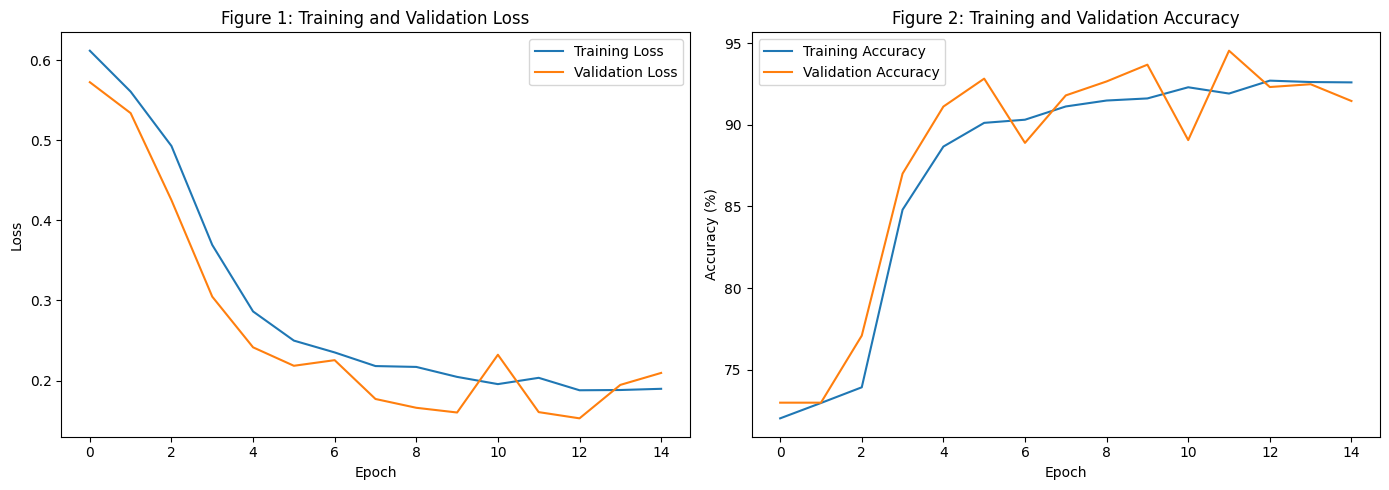

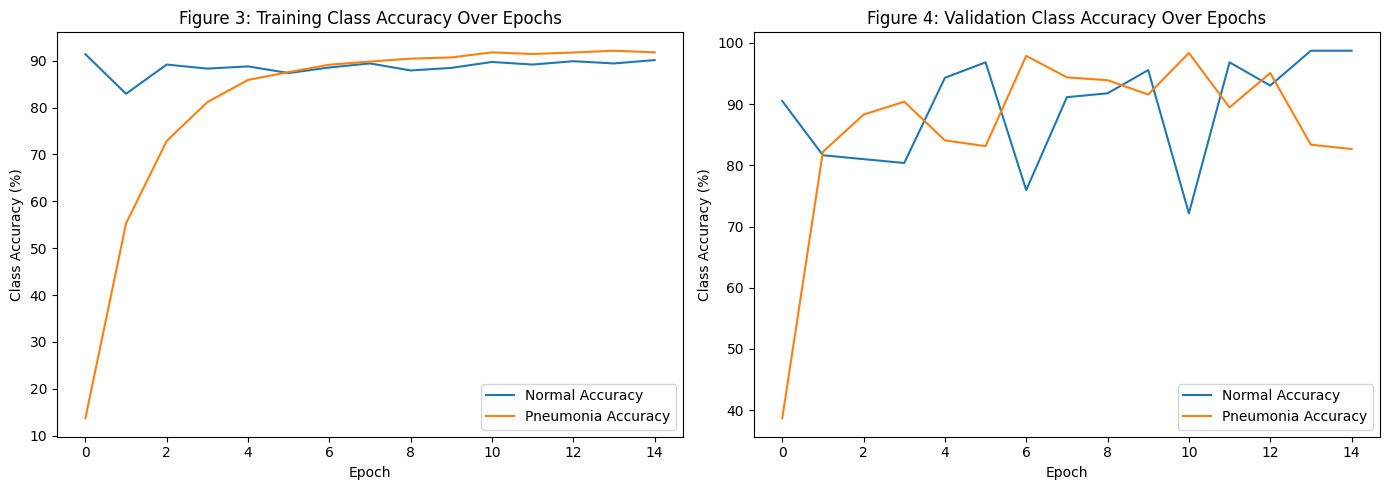

Model saved as 'chest_xray_model(baseline).pth'


In [19]:
# Initialize the model
model_SimpleModel = SimpleModel().to(device)

# Define loss function and optimizer

criterion_SimpleModel = nn.CrossEntropyLoss()

optimizer_SimpleModel = torch.optim.SGD(model_SimpleModel.parameters(), lr=lr)


# Train the model
train_losses_SimpleModel, train_accuracies_SimpleModel, val_losses_SimpleModel, val_accuracies_SimpleModel, train_class_accuracies_SimpleModel, val_class_accuracies_SimpleModel = train_model(
    model_SimpleModel, train_loader_SimpleModel, val_loader_SimpleModel, criterion_SimpleModel, optimizer_SimpleModel, num_epochs, device, use_wandb=use_wandb
)

# Plot training curves
plot_training_curves(train_losses_SimpleModel, train_accuracies_SimpleModel, val_losses_SimpleModel, val_accuracies_SimpleModel, train_class_accuracies_SimpleModel, val_class_accuracies_SimpleModel)

# Save the model
torch.save(model_SimpleModel.state_dict(), 'chest_xray_model(baseline).pth')
print("Model saved as 'chest_xray_model(baseline).pth'")

**(a)**

_Insert brief explanation of the design choices you made_

## For the baseline model, i have chosen to use a simple Convolutional neural network as it has the ability to scan across local regions. This allows CNN to detect straignt lines, sharp edges or colours, these can then build onto detecting complex features like shapes and objects, this helps to create a heirarchal understanding of the image.

## I have also used a resize transform of 128 X 128, which allows the model the receive images of equal size, the resize of 128 X 128 is chosen instead of 64 X 64 to preserve as much detail of the image as possible. 128 x 128 resolution is used to retain critical image detail, enhancing the model's ability to detect subtle changes. this is very important for this model to detect pneumonia as subtle, minor texture changes is very essential for the correct diagnosis.

## Furthermore, i have used 3 input channel(i.e used RGB pannels instead of one grayscale pannel) even though xrays would be grayscale. This is because CNNs are excellent at detecting complex patterns, by using 3 channels the models has effectively more parameters to work with. which could help the model learn more complex patterns.

##Also, i have used logists to pass my output, this is because i am using Cross Entropy loss which implicitily includes softmax,  When you pass logits to cross-entropy loss, it computes softmax internally and combines it with the log operation, saving computation and reducing memory usage.



**(b)**

_Present your results, including plots etc. here_


The results are shown above, right below the code.

**(c)**

_Discuss your results here_
The results are shown above.

## **Figure 1:** Initially, both the training and validation losses decrease gradually, but about epoch 6, the validation loss starts to show small oscillations which could be a sign of possible overfitting or noise in validation performance, however, both validation and training losses somewhat converge.

## **Figure 2:**  Both the training and validation accuracies increase rapidly then level off at about epoch 6. Generalisation may be required for the model as the validate accuracy starts to oscillate, however, the close accuracy values of the validation and the training suggests that it is a good fit.

## **Figure 3:** For the training class accuracy both the normal and pneumonia class achieve a high values suggesting that the model has effectively learning from these two classes.

## **Figure 4:** For validation class accuracy, the amount of fluctuations between both the class are different, suggesting a class imbalance impact on the models performance or the difficulty in observe complex pneumonia patterns in the X-rays.

## Overall the model demonstrates both the validation and training loss converging and a strong alignment betwwen training and validation accuracity which could indicate good generaliation. However, pneumonia class summer very drastic oscillations in class specific accuracies which may suggest that class imbalaces that i mentioned earlier still may affect the models performance.

#  Improving the Baseline 


## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



tensor(0.4833) tensor(0.2214)


Epoch [1/10], Train Loss: 0.3962, Train Acc: 82.88%, Val Loss: 0.2855, Val Acc: 90.77%


Epoch [2/10], Train Loss: 0.2479, Train Acc: 89.94%, Val Loss: 0.1764, Val Acc: 94.19%


Epoch [3/10], Train Loss: 0.2140, Train Acc: 91.35%, Val Loss: 0.1661, Val Acc: 93.16%


Epoch [4/10], Train Loss: 0.1923, Train Acc: 92.51%, Val Loss: 0.1237, Val Acc: 96.07%


Epoch [5/10], Train Loss: 0.1772, Train Acc: 92.74%, Val Loss: 0.1393, Val Acc: 95.38%


Epoch [6/10], Train Loss: 0.1658, Train Acc: 93.77%, Val Loss: 0.1110, Val Acc: 96.07%


Epoch [7/10], Train Loss: 0.1615, Train Acc: 93.87%, Val Loss: 0.1409, Val Acc: 94.02%


Epoch [8/10], Train Loss: 0.1539, Train Acc: 94.17%, Val Loss: 0.1133, Val Acc: 95.04%


Epoch [9/10], Train Loss: 0.1531, Train Acc: 93.94%, Val Loss: 0.1124, Val Acc: 94.70%


Epoch [10/10], Train Loss: 0.1513, Train Acc: 94.24%, Val Loss: 0.0988, Val Acc: 96.24%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▆▇▇█████
Train Loss,█▄▃▂▂▁▁▁▁▁
Training Class Accuracy/Normal,▁▆▆▇▇█▇███
Training Class Accuracy/Pneumonia,▁▆▇▇▇█████
Validation Accuracy,▁▅▄█▇█▅▆▆█
Validation Class Accuracy/Normal,█▄▁▅█▆▂▃▄▅
Validation Class Accuracy/Pneumonia,▁▆▇▇▅▇████
Validation Loss,█▄▄▂▃▁▃▂▂▁
Epoch,10


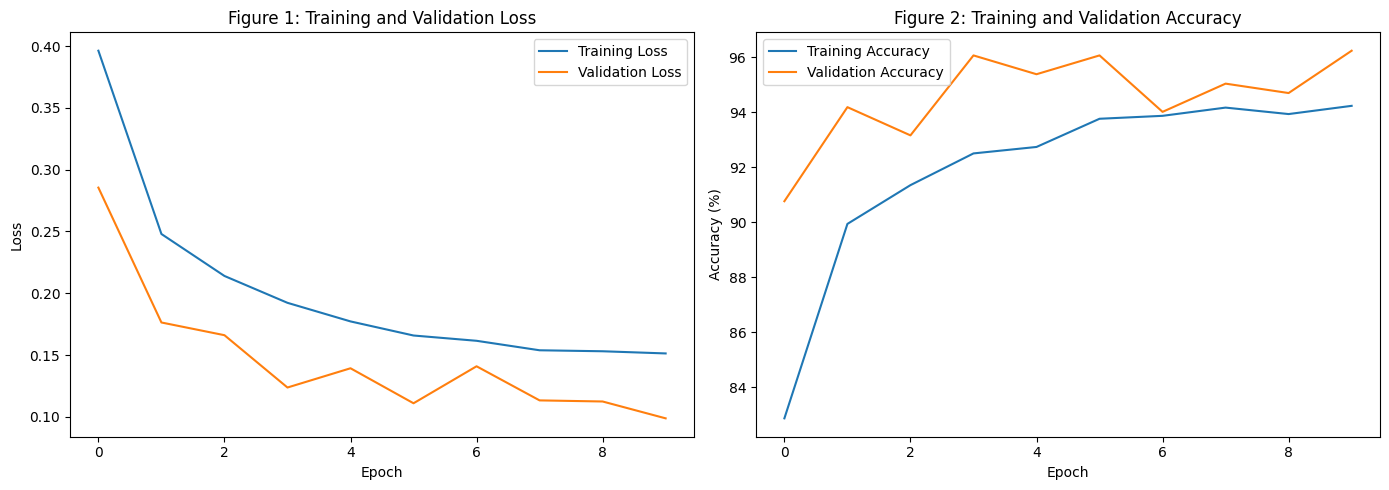

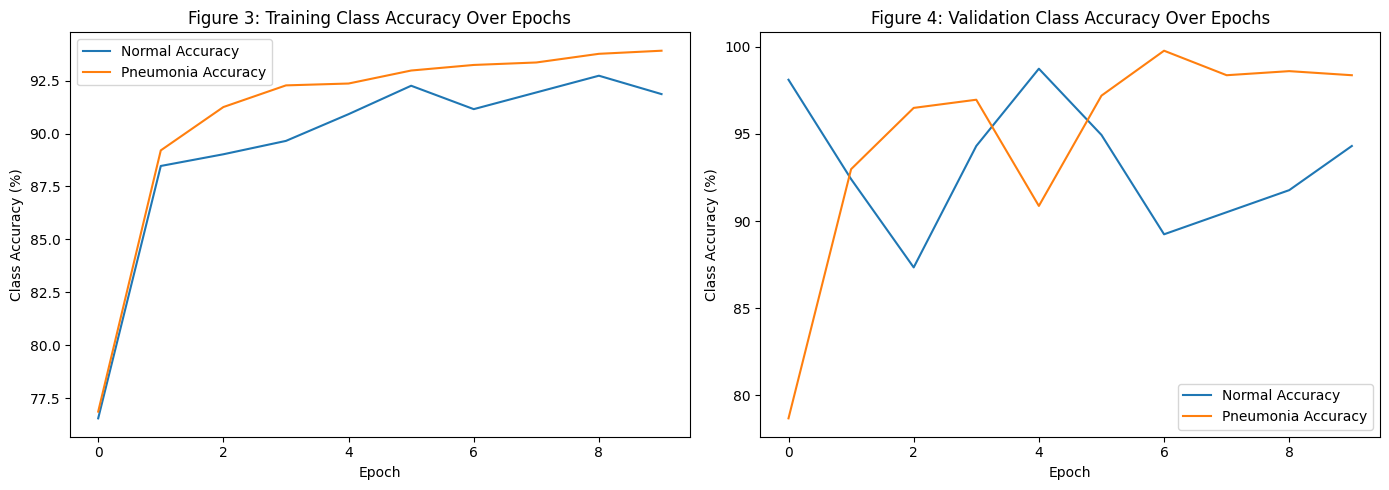

Model saved as 'chest_xray_model(full improvement).pth'


In [20]:
# Implement the improvements and train the model in as many cells as you need.


#Calculating the mean and standard deviaiton of images for normalisation
mean = torch.tensor(0.0)
std = torch.tensor(0.0)

for images, _ in train_loader_SimpleModel:
    batch_samples = images.size(0)
    images = images.view(batch_size, -1)
    mean += images.mean(1).sum()
    std += images.std(1).sum()

mean /= len(train_loader_SimpleModel.dataset)
std /= len(train_loader_SimpleModel.dataset)

mean_list = mean.tolist()
std_list = std.tolist()

print(mean, std)

#Data augmentation(IMPROVEMENT NUMBER 1)
transform_imp = transforms.Compose([
    transforms.Resize((128, 128)),                # Resize images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),     # Randomly flip images horizontally with a 50% probability
    transforms.RandomRotation(degrees=5),      # Randomly rotate images by up to ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                      # Convert images to tensors
    transforms.Normalize(mean=mean_list, std=std_list)  # Normalize images
    ])


# [0.4813, 0.4813, 0.4813], std=[0.2180, 0.2180, 0.2180])

train_dataset_imp = ChestXrayDataset(root_dir=dataset_path, transform=transform_imp)         #'''check root_dir value is correct from the email.'''
test_dataset_imp = ChestXrayDataset(root_dir=dataset_path, split='test', transform=transform_imp)
val_dataset_imp = ChestXrayDataset(root_dir=dataset_path, split='val', transform=transform_imp)

# Create data loaders

train_loader_imp = DataLoader(train_dataset_imp, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)            #What do these do? num_workers=2, pin_memory=True
test_loader_imp = DataLoader(test_dataset_imp, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader_imp = DataLoader(val_dataset_imp, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



#improved CNN with batch normalisation and dropoout(IMPROVEMENT NUMBER 2)
class EnhancedModel_imp(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Downsamples to 64x64

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Downsamples to 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Downsamples to 16x16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Downsamples to 8x8

            nn.Flatten(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(8 * 8 * 128, 64),  # Fully connected layer with 64 neurons
            nn.ReLU(),
            nn.Linear(64, 2)  # Output layer for binary classification
        )
    def forward(self, x):
        return self.network(x)

# Initialize and summarize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the model.
model_imp = EnhancedModel_imp().to(device)

# Use loss function
criterion_imp = nn.CrossEntropyLoss()

# Define loss function and optimizer
optimizer_imp = torch.optim.SGD(model_imp.parameters(), lr=lr)
num_epochs = 10

# Train the model
train_losses_imp, train_accuracies_imp, val_losses_imp, val_accuracies_imp, train_class_accuracies_imp, val_class_accuracies_imp = train_model(model_imp,
    train_loader_imp, val_loader_imp, criterion_imp, optimizer_imp, num_epochs, device, use_wandb)

# Plot training curves
plot_training_curves(train_losses_imp, train_accuracies_imp, val_losses_imp, val_accuracies_imp, train_class_accuracies_imp, val_class_accuracies_imp)

# Save the model
torch.save(model_imp.state_dict(), 'chest_xray_model(full improvement).pth')
print("Model saved as 'chest_xray_model(full improvement).pth'")

**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*
I AM CHOSEN THE


## 1. **Data augmentation.** Applied random horizontal flips, small-angle rotations, and colour jitter to increase data diversity. This increases the diversity of the dataset for the model, which helps to generalise the reduce chances of overfitting. The baseline shows some signs of overfitting which data augmentation can be used to help where training accuracy was high, but validation accuracy improvements were limited. Hence Data augmentation can help increase the variaty of the input images and reduce the changes of the model memorising the data.

##2. **Early stopping(reducing epochs):** Stopping the model early before the model starts to memorise the data and cause overfitting.The baseline showed some signs of overfitting as training loss kept decreasing with minimal improvement in validation accuracy, suggesting that fewer epochs might improve generalisation. By stopping early, the model is prevented from traing on patterns that are only unique to the training data.

##3. **Improved CNN Architecture with Dropout and Batch Normalisation:** more layers of CNN are added along with batch normalisation to stabilise learning and dropout for regularisation. A more complex CNN model can capture more complicated patterns in an Xray. The baseline models validation were seen to be fluctuating. A more complex CNN could help with this.




**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)


The results for the baseline + 3 improvements are shown below.

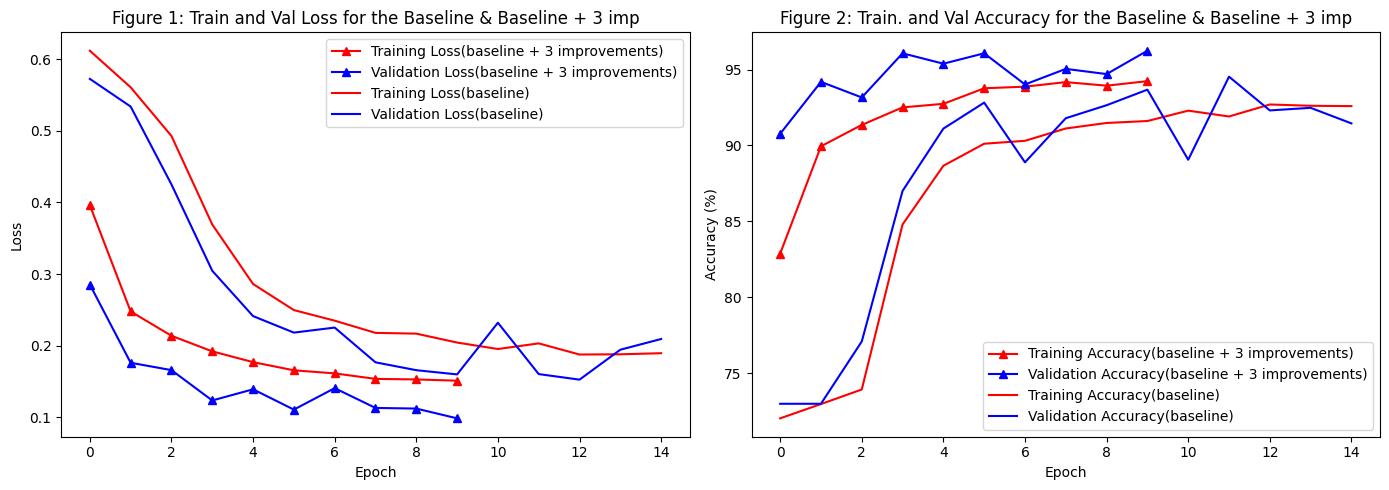

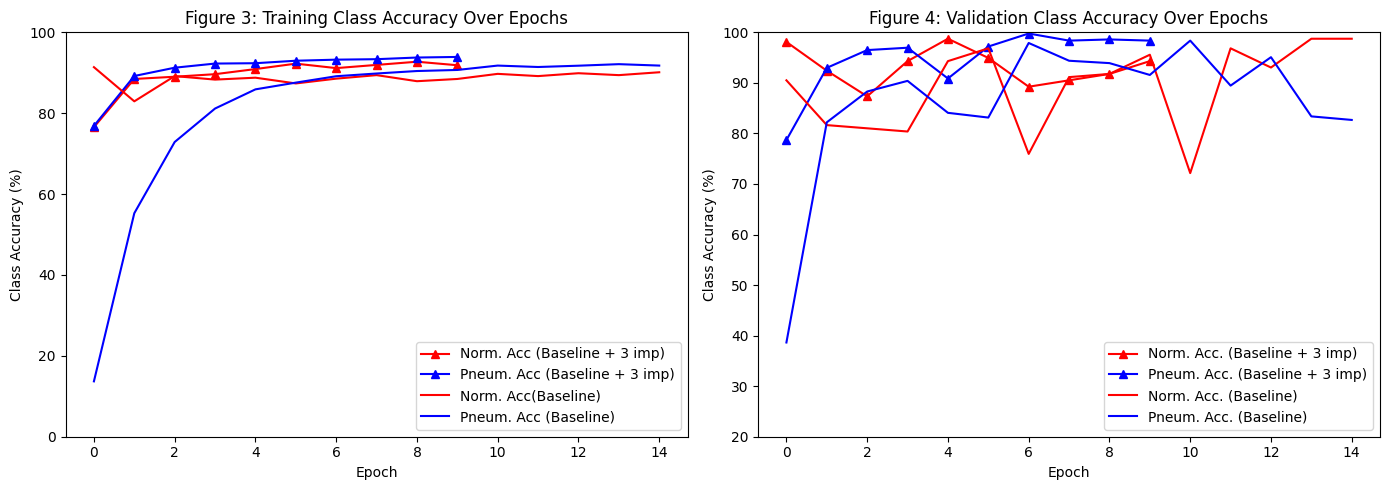

In [56]:
#COMPARING BASELINE + 3 IMPROVEMENTS WITH BASELINE MODEL


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_imp, label='Training Loss(baseline + 3 improvements)', marker='^', linestyle='-',color='Red')
plt.plot(val_losses_imp, label='Validation Loss(baseline + 3 improvements)', marker='^', linestyle='-',color='Blue')
plt.plot(train_losses_SimpleModel, label='Training Loss(baseline)', linestyle='-',color='Red')
plt.plot(val_losses_SimpleModel, label='Validation Loss(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Figure 1: Train and Val Loss for the Baseline & Baseline + 3 imp')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_imp, label='Training Accuracy(baseline + 3 improvements)',marker='^', linestyle='-',color='Red')
plt.plot(val_accuracies_imp, label='Validation Accuracy(baseline + 3 improvements)', marker='^', linestyle='-',color='Blue')
plt.plot(train_accuracies_SimpleModel, label='Training Accuracy(baseline)', linestyle='-',color='Red')
plt.plot(val_accuracies_SimpleModel, label='Validation Accuracy(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Figure 2: Train. and Val Accuracy for the Baseline & Baseline + 3 imp')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 5))

# Extract values for each class from training and validation accuracies
train_class1_accuracies = [acc[0] for acc in train_class_accuracies_imp]  # Class 1 in training
train_class2_accuracies = [acc[1] for acc in train_class_accuracies_imp]  # Class 2 in training

val_class1_accuracies = [acc[0] for acc in val_class_accuracies_imp]      # Class 1 in validation
val_class2_accuracies = [acc[1] for acc in val_class_accuracies_imp]      # Class 2 in validation

train_class1_accuracies2= [acc[0] for acc in train_class_accuracies_SimpleModel]  # Class 1 in training
train_class2_accuracies2 = [acc[1] for acc in train_class_accuracies_SimpleModel]  # Class 2 in training

val_class1_accuracies2 = [acc[0] for acc in val_class_accuracies_SimpleModel]      # Class 1 in validation
val_class2_accuracies2 = [acc[1] for acc in val_class_accuracies_SimpleModel]      # Class 2 in validation

# Training Class Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_class1_accuracies, label='Norm. Acc (Baseline + 3 imp)', marker='^', linestyle='-',color='Red')
plt.plot(train_class2_accuracies, label='Pneum. Acc (Baseline + 3 imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_class1_accuracies2, label='Norm. Acc(Baseline)', linestyle='-',color='Red')
plt.plot(train_class2_accuracies2, label='Pneum. Acc (Baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Figure 3: Training Class Accuracy Over Epochs')
plt.ylim(0, 100)  # Set the y-axis range
plt.legend()

# Validation Class Accuracy Plot
plt.subplot(1, 2, 2)


plt.plot(val_class1_accuracies, label='Norm. Acc. (Baseline + 3 imp)', marker='^', linestyle='-',color='Red')
plt.plot(val_class2_accuracies, label='Pneum. Acc. (Baseline + 3 imp)', marker='^', linestyle='-',color='Blue')
plt.plot(val_class1_accuracies2, label='Norm. Acc. (Baseline)', linestyle='-',color='Red')
plt.plot(val_class2_accuracies2, label='Pneum. Acc. (Baseline)', linestyle='-',color='Blue')

plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Figure 4: Validation Class Accuracy Over Epochs')
plt.ylim(20, 100)  # Set the y-axis range

plt.legend()

plt.tight_layout()
plt.show()

**(c)**

##**Train and validation losses for both models**


##**From Fig. 1:**


##It is clear the training and validation losses for the improved model shows lower overall losses, and more gradual decrease.

##The validation loss and training loss for the baseline model shows a big gap between them whicch may suggest overfitten, furthermore the baseline validation and training losses start to fluctuate at about the 8th epoch, which could mean the model isn't generalising well enough.

##One the other hand the validation and training loss for the improvement model shows a rapid decrease at the start suggesting that the model is learning more quickly. Also the validaiton loss for the improved model is relatively lower with little to no fluctuation, this could be due to adding batch normaliation and dropouts that may have contributed to better generalization and reduced overfittingelped

##Fig 2.

##The figure shows the training and validation accuracies for the baseline and the improvement model. It is clear to see the validation accuracy for the improved model is relatively higher and fluctuates less compared to the one of the baseline model, this suggest the new model has lowered the possible overfitting. Also even though the validatin and training accuracies of the baseline model reach high accuracy of about 90%, it might still not generalize well due to the lack of regularization techniques.

##On the other hand the validation acccuracy of the improved model is stable and stays consistently high suggesting better generalization to validation data.

##Fig 3 and 4.
##The accuracies for the improved model reaches a stable accuracy of about 90% for both the classes showing effective learning and convergence, also the improved models validation losses are more higher and stable compared to the baseline, which suggests reduced overfitting and better generalization, while the baseline model shows more fluctuation, especially for the Pneumonia class.


##Also the improved model also has reduced opoches, as this can reduce computational time without reducing performance. Furthermore, figure one and two show the training loss and accuracy steadily improving across epochs, but the validation accuracy plateaus and fluctuates. Continuing to train beyond the point where validation performance stabilizes increases the risk of the model being overfitted.

## Empirically justifying improvement 1 

**I HAVE CHOSEN THE SECOND OPTION, Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement.**

Epoch [1/15], Train Loss: 0.5318, Train Acc: 75.41%, Val Loss: 0.4655, Val Acc: 77.26%


Epoch [2/15], Train Loss: 0.3826, Train Acc: 84.97%, Val Loss: 0.2844, Val Acc: 90.26%


Epoch [3/15], Train Loss: 0.2689, Train Acc: 88.98%, Val Loss: 0.2036, Val Acc: 93.16%


Epoch [4/15], Train Loss: 0.2189, Train Acc: 91.50%, Val Loss: 0.1947, Val Acc: 92.31%


Epoch [5/15], Train Loss: 0.2105, Train Acc: 91.46%, Val Loss: 0.1648, Val Acc: 94.36%


Epoch [6/15], Train Loss: 0.2030, Train Acc: 91.70%, Val Loss: 0.1750, Val Acc: 93.50%


Epoch [7/15], Train Loss: 0.1931, Train Acc: 92.61%, Val Loss: 0.2411, Val Acc: 89.57%


Epoch [8/15], Train Loss: 0.1871, Train Acc: 92.98%, Val Loss: 0.1587, Val Acc: 93.16%


Epoch [9/15], Train Loss: 0.1858, Train Acc: 92.68%, Val Loss: 0.1457, Val Acc: 94.87%


Epoch [10/15], Train Loss: 0.1917, Train Acc: 92.66%, Val Loss: 0.1595, Val Acc: 94.87%


Epoch [11/15], Train Loss: 0.1844, Train Acc: 92.85%, Val Loss: 0.1462, Val Acc: 94.02%


Epoch [12/15], Train Loss: 0.1807, Train Acc: 92.95%, Val Loss: 0.1521, Val Acc: 93.85%


Epoch [13/15], Train Loss: 0.1761, Train Acc: 93.13%, Val Loss: 0.1468, Val Acc: 94.02%


Epoch [14/15], Train Loss: 0.1734, Train Acc: 93.55%, Val Loss: 0.1485, Val Acc: 94.02%


Epoch [15/15], Train Loss: 0.1722, Train Acc: 93.30%, Val Loss: 0.1360, Val Acc: 95.38%


Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▆▇▇▇█████████
Train Loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
Training Class Accuracy/Normal,▁▁▆▇▅▅▅▆▅▄▅▆█▆█
Training Class Accuracy/Pneumonia,▁▅▇▇▇██████████
Validation Accuracy,▁▆▇▇█▇▆▇██▇▇▇▇█
Validation Class Accuracy/Normal,▁▆▇█▇█▃▇▇▅▇█▇█▆
Validation Class Accuracy/Pneumonia,▁▃▄▃▅▄█▅▆▇▅▄▅▄▇
Validation Loss,█▄▂▂▂▂▃▁▁▁▁▁▁▁▁
Epoch,15


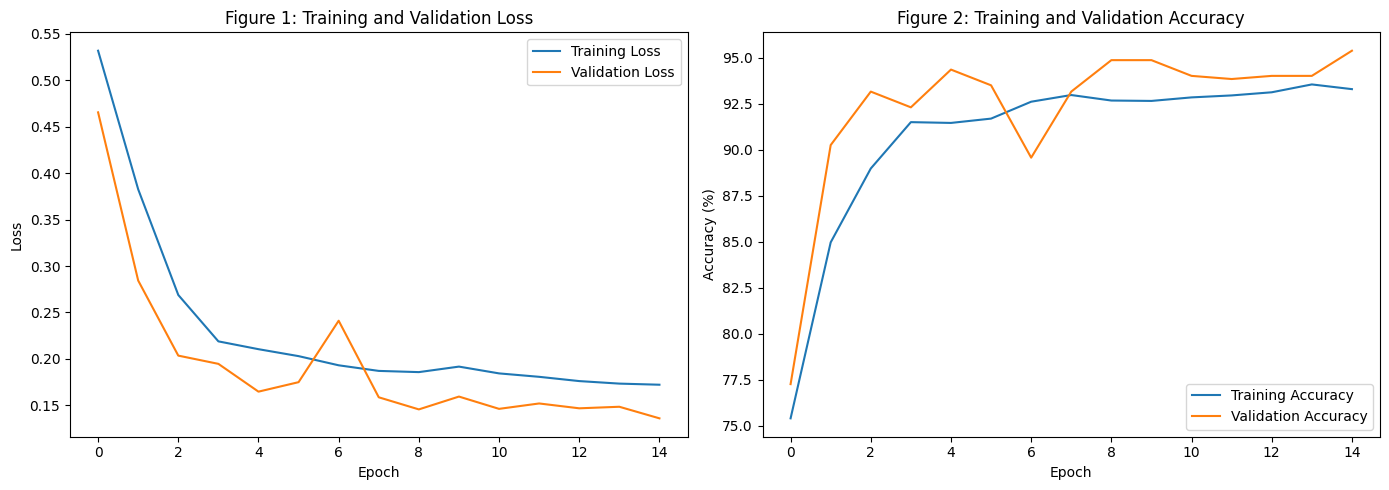

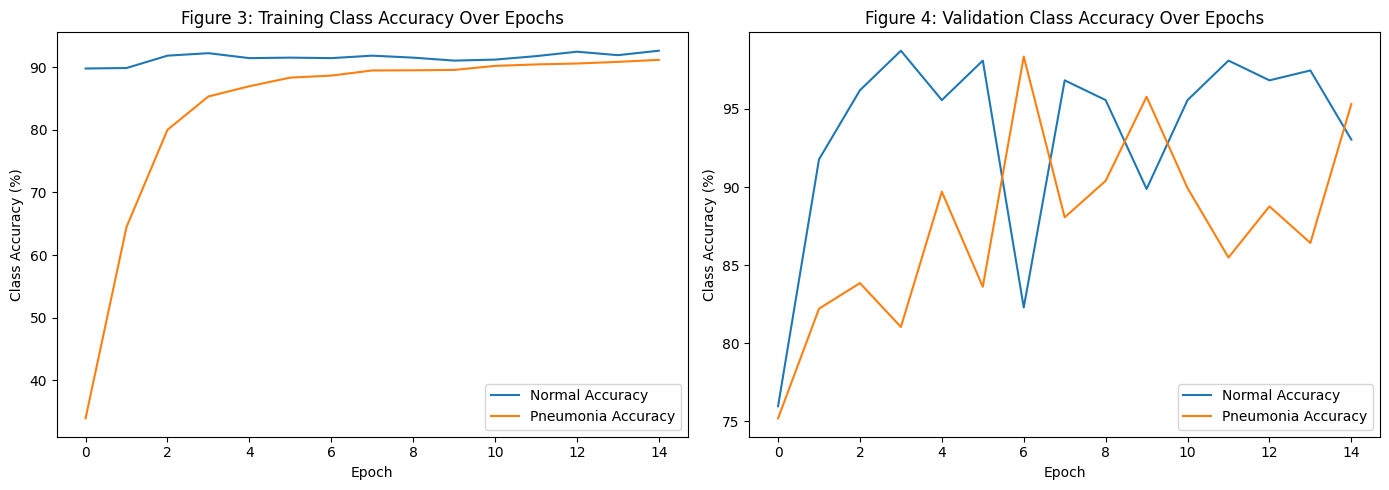

Model saved as 'chest_xray_model(imp1).pth'


In [23]:
# Implement the experiment in as many cells as you need.
# DATA AUGMENTATION
transform_imp1 = transforms.Compose([
    transforms.Resize((128, 128)),                # Resize images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),     # Randomly flip images horizontally with a 50% probability
    transforms.RandomRotation(degrees=5),      # Randomly rotate images by up to ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                      # Convert images to tensors
    transforms.Normalize(mean=[0.4813, 0.4813, 0.4813], std=[0.2180, 0.2180, 0.2180])  # Normalize images
    ])

train_dataset_imp1 = ChestXrayDataset(root_dir=dataset_path, transform=transform_imp1)         #'''check root_dir value is correct from the email.'''
test_dataset_imp1 = ChestXrayDataset(root_dir=dataset_path, split='test', transform=transform_imp1)
val_dataset_imp1 = ChestXrayDataset(root_dir=dataset_path, split='val', transform=transform_imp1)


# Create data loaders

train_loader_imp1 = DataLoader(train_dataset_imp1, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)            #What do these do? num_workers=2, pin_memory=True
test_loader_imp1 = DataLoader(test_dataset_imp1, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader_imp1 = DataLoader(val_dataset_imp1, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Initialize the model
model_imp1 = SimpleModel().to(device)

# Define loss function and optimizer

criterion_imp1 = nn.CrossEntropyLoss()

optimizer_imp1 = torch.optim.SGD(model_imp1.parameters(), lr=lr)

num_epochs = 15
# Train the model
train_losses_imp1, train_accuracies_imp1, val_losses_imp1, val_accuracies_imp1, train_class_accuracies_imp1, val_class_accuracies_imp1 = train_model(
    model_imp1, train_loader_imp1, val_loader_imp1, criterion_imp1, optimizer_imp1, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses_imp1, train_accuracies_imp1, val_losses_imp1, val_accuracies_imp1, train_class_accuracies_imp1, val_class_accuracies_imp1)

# Save the model
torch.save(model_imp1.state_dict(), 'chest_xray_model(imp1).pth')
print("Model saved as 'chest_xray_model(imp1).pth'")

**(a)**

**I HAVE CHOSEN THE SECOND OPTION, Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement.**
##Data Augmentation

**(b)**

_Present your results, including plots etc, here_

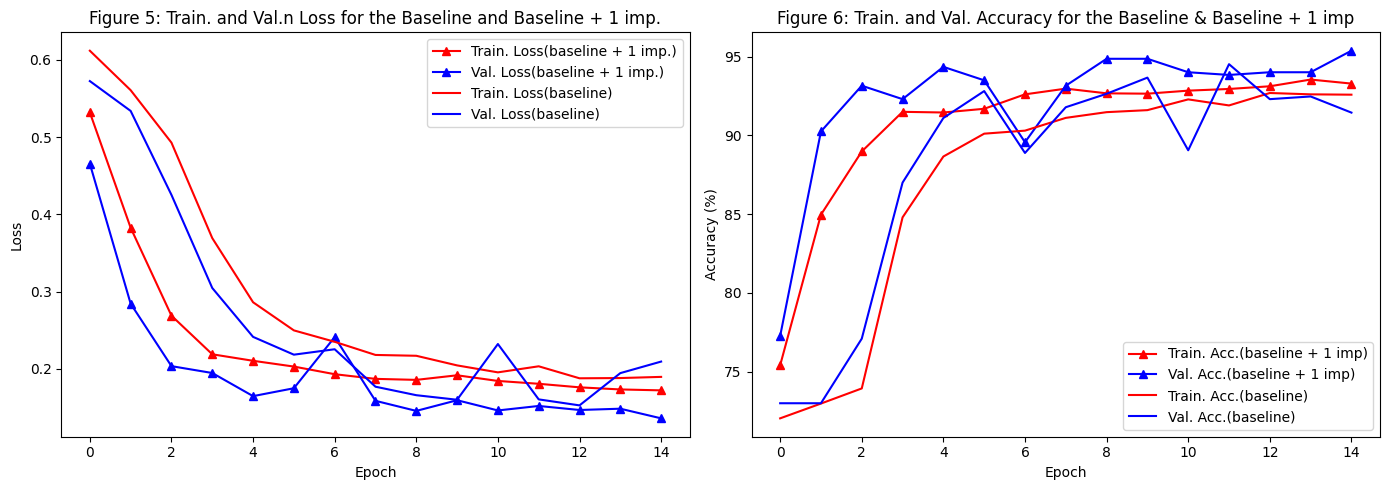

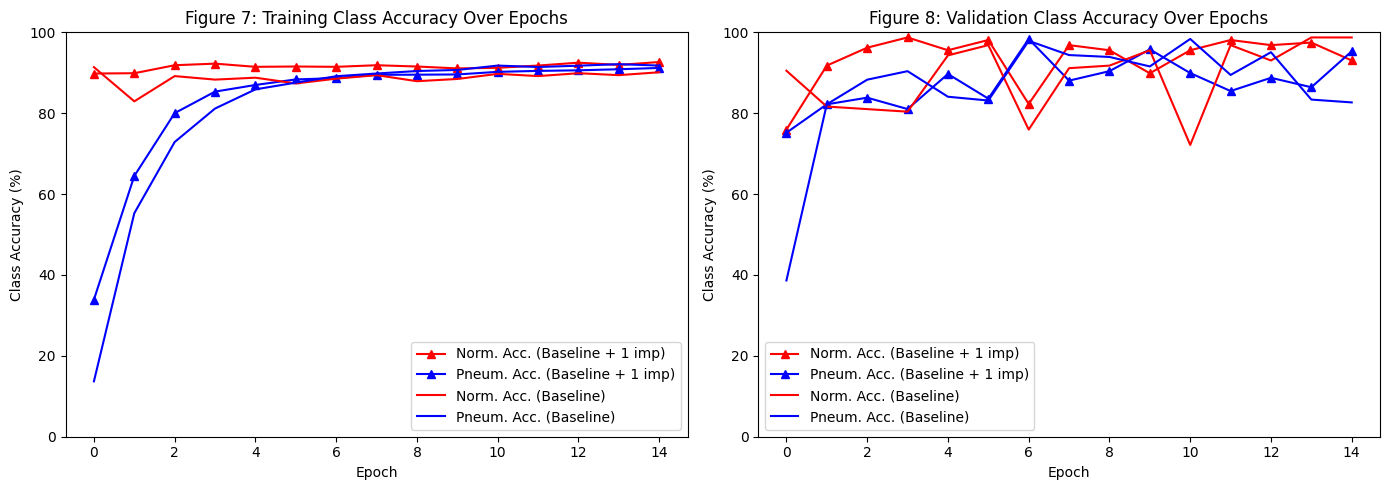

In [58]:
# train_losses_imp, train_accuracies_imp, val_losses_imp, val_accuracies_imp, train_class_accuracies_imp, val_class_accuracies_imp
# train_losses_SimpleModel, train_accuracies_SimpleModel, val_losses_SimpleModel, val_accuracies_SimpleModel, train_class_accuracies_SimpleModel, val_class_accuracies_SimpleModel
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_imp1, label='Train. Loss(baseline + 1 imp.)', marker='^', linestyle='-',color='Red')
plt.plot(val_losses_imp1, label='Val. Loss(baseline + 1 imp.)', marker='^', linestyle='-',color='Blue')
plt.plot(train_losses_SimpleModel, label='Train. Loss(baseline)', linestyle='-',color='Red')
plt.plot(val_losses_SimpleModel, label='Val. Loss(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Figure 5: Train. and Val.n Loss for the Baseline and Baseline + 1 imp.')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_imp1, label='Train. Acc.(baseline + 1 imp)',marker='^', linestyle='-',color='Red')
plt.plot(val_accuracies_imp1, label='Val. Acc.(baseline + 1 imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_accuracies_SimpleModel, label='Train. Acc.(baseline)', linestyle='-',color='Red')
plt.plot(val_accuracies_SimpleModel, label='Val. Acc.(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Figure 6: Train. and Val. Accuracy for the Baseline & Baseline + 1 imp')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 5))

# Extract values for each class from training and validation accuracies
train_class1_accuracies3 = [acc[0] for acc in train_class_accuracies_imp1]  # Class 1 in training
train_class2_accuracies3 = [acc[1] for acc in train_class_accuracies_imp1]  # Class 2 in training

val_class1_accuracies3 = [acc[0] for acc in val_class_accuracies_imp1]      # Class 1 in validation
val_class2_accuracies3 = [acc[1] for acc in val_class_accuracies_imp1]      # Class 2 in validation

train_class1_accuracies2= [acc[0] for acc in train_class_accuracies_SimpleModel]  # Class 1 in training
train_class2_accuracies2 = [acc[1] for acc in train_class_accuracies_SimpleModel]  # Class 2 in training

val_class1_accuracies2 = [acc[0] for acc in val_class_accuracies_SimpleModel]      # Class 1 in validation
val_class2_accuracies2 = [acc[1] for acc in val_class_accuracies_SimpleModel]      # Class 2 in validation

# Training Class Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_class1_accuracies3, label='Norm. Acc. (Baseline + 1 imp)', marker='^', linestyle='-',color='Red')
plt.plot(train_class2_accuracies3, label='Pneum. Acc. (Baseline + 1 imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_class1_accuracies2, label='Norm. Acc. (Baseline)', linestyle='-',color='Red')
plt.plot(train_class2_accuracies2, label='Pneum. Acc. (Baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Figure 7: Training Class Accuracy Over Epochs')
plt.ylim(0, 100)  # Set the y-axis range
plt.legend()

# Validation Class Accuracy Plot
plt.subplot(1, 2, 2)


plt.plot(val_class1_accuracies3, label='Norm. Acc. (Baseline + 1 imp)', marker='^', linestyle='-',color='Red')
plt.plot(val_class2_accuracies3, label='Pneum. Acc. (Baseline + 1 imp)', marker='^', linestyle='-',color='Blue')
plt.plot(val_class1_accuracies2, label='Norm. Acc. (Baseline)', linestyle='-',color='Red')
plt.plot(val_class2_accuracies2, label='Pneum. Acc. (Baseline)', linestyle='-',color='Blue')

plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Figure 8: Validation Class Accuracy Over Epochs')
plt.ylim(0, 100)  # Set the y-axis range
plt.legend()

plt.tight_layout()
plt.show()

**(c)**

_Discuss your results here_


##I HAVE CHOSEN THE SECOND OPTION OF SHOWING ONE INDIVIDUAL IMPROVEMENT ON THE BASELINE MODEL(This is Data Augmentation with the baseline model)

##I have applied data Augmention using random horizontal flips, small-angle rotations, and colour jitter to increase data diversity.
##This increases the diversity of the dataset for the model, which helps to generalise the reduce chances of overfitting. The baseline shows some signs of overfitting which data augmentation can be used to help where training accuracy was high, but validation accuracy improvements were limited. Hence Data augmentation can help increase the variety of the input images and reduce the changes of the model memorising the data.

##By looking Fig 1 and 2.(only improved model plot), the validation and training loss go down as expected, along with incresed validaton and training accuracies with epoch. Comparing the (baseline + 1 improvement) to the baseline model, by looking at fig 5,6, the validation and training losses go down much quickly suggesting quicker learning, ther is also reduced fluctuations in the validation loss as opochs increase, suggesting higher generaliation.

##The validation and training accuracies also increase more quickly than the baseline, and have less fluctuations suggesting improvements. Similarly the class validattion accuracies for pneumonia in improvement model have lower fluctuations, indicating that the model is achieving more stable predictions across epochs. This stability suggests enhanced generalization

##Overall, adding Data augmentation has clearly improved the baseline model, hence it is an excellent addition to improve the performance of the final model.

## Empirically justifying improvement 2 

Epoch [1/15], Train Loss: 0.3356, Train Acc: 85.46%, Val Loss: 0.2014, Val Acc: 91.97%


Epoch [2/15], Train Loss: 0.2124, Train Acc: 91.63%, Val Loss: 0.1507, Val Acc: 94.36%


Epoch [3/15], Train Loss: 0.1732, Train Acc: 93.45%, Val Loss: 0.1328, Val Acc: 95.56%


Epoch [4/15], Train Loss: 0.1574, Train Acc: 94.04%, Val Loss: 0.1247, Val Acc: 95.38%


Epoch [5/15], Train Loss: 0.1378, Train Acc: 94.66%, Val Loss: 0.1029, Val Acc: 96.58%


Epoch [6/15], Train Loss: 0.1385, Train Acc: 94.77%, Val Loss: 0.0990, Val Acc: 96.24%


Epoch [7/15], Train Loss: 0.1332, Train Acc: 94.83%, Val Loss: 0.1529, Val Acc: 94.02%


Epoch [8/15], Train Loss: 0.1266, Train Acc: 95.56%, Val Loss: 0.0927, Val Acc: 96.24%


Epoch [9/15], Train Loss: 0.1242, Train Acc: 95.35%, Val Loss: 0.0921, Val Acc: 96.24%


Epoch [10/15], Train Loss: 0.1162, Train Acc: 95.67%, Val Loss: 0.0956, Val Acc: 96.24%


Epoch [11/15], Train Loss: 0.1104, Train Acc: 95.62%, Val Loss: 0.0850, Val Acc: 97.44%


Epoch [12/15], Train Loss: 0.1118, Train Acc: 95.94%, Val Loss: 0.0849, Val Acc: 97.09%


Epoch [13/15], Train Loss: 0.1084, Train Acc: 96.16%, Val Loss: 0.0820, Val Acc: 97.09%


Epoch [14/15], Train Loss: 0.1069, Train Acc: 96.24%, Val Loss: 0.0713, Val Acc: 97.44%


Epoch [15/15], Train Loss: 0.1002, Train Acc: 96.14%, Val Loss: 0.0702, Val Acc: 97.26%


Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▆▇▇▇▇█▇██████
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Training Class Accuracy/Normal,▁▂▄▅▆▆▆▆▆▆▇▇▇██
Training Class Accuracy/Pneumonia,▁▆▇▇▇▇▇████████
Validation Accuracy,▁▄▆▅▇▆▄▆▆▆█████
Validation Class Accuracy/Normal,▁▅▆▇▆▇█▇▇▃▅██▇▇
Validation Class Accuracy/Pneumonia,▄▄▄▃▆▆▁▅▅█▇▅▅▇▆
Validation Loss,█▅▄▄▃▃▅▂▂▂▂▂▂▁▁
Epoch,15


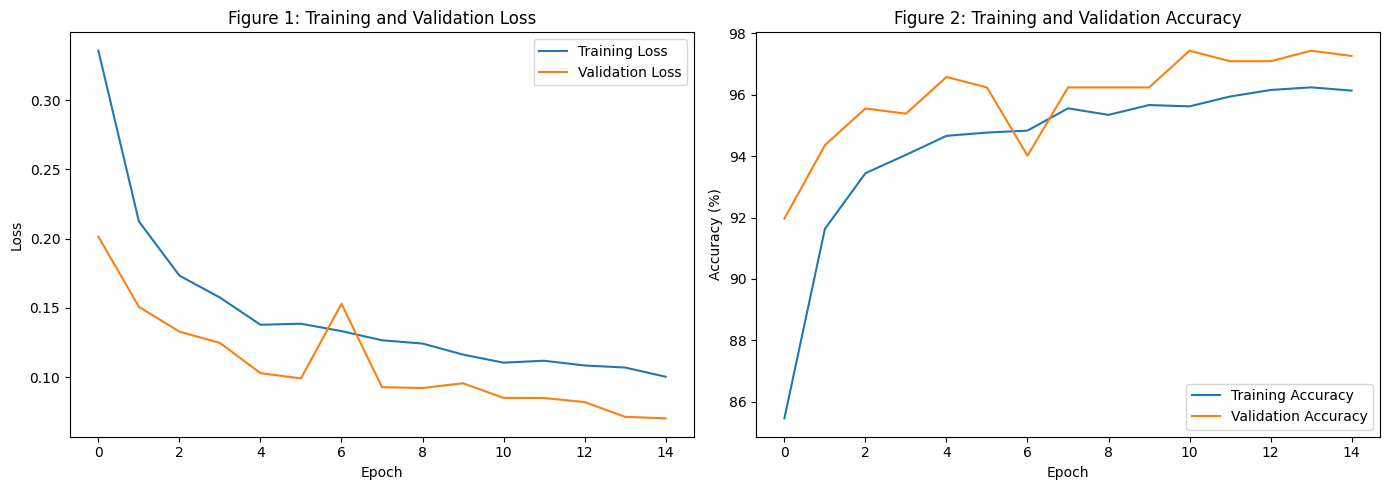

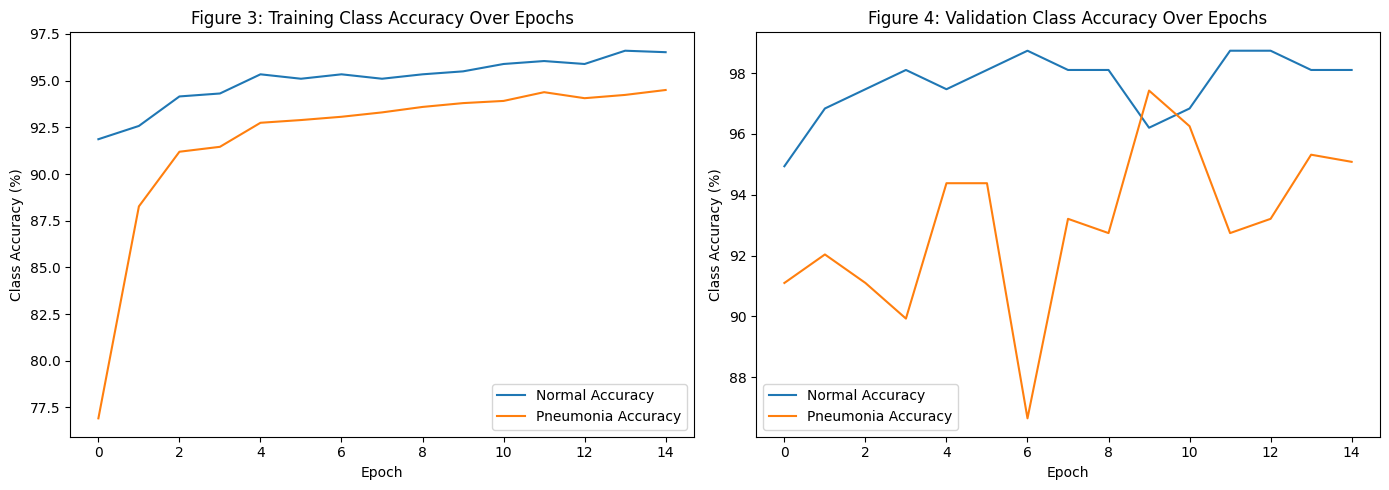

Model saved as 'chest_xray_model(im2).pth'


In [34]:

# Initialize and summarize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the model.
model_imp2 = EnhancedModel_imp().to(device)

# Use weighted loss function
criterion_imp2 = nn.CrossEntropyLoss()

# Define loss function and optimizer
optimizer_imp2 = torch.optim.SGD(model_imp2.parameters(), lr=lr)
# Train the model
num_epochs = 15
train_losses_imp2, train_accuracies_imp2, val_losses_imp2, val_accuracies_imp2, train_class_accuracies_imp2, val_class_accuracies_imp2 = train_model(model_imp2, train_loader_SimpleModel, val_loader_SimpleModel, criterion_imp2, optimizer_imp2, num_epochs, device, use_wandb)

# Plot training curves
plot_training_curves(train_losses_imp2, train_accuracies_imp2, val_losses_imp2, val_accuracies_imp2, train_class_accuracies_imp2, val_class_accuracies_imp2)

# Save the model
torch.save(model_imp2.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model(im2).pth'")


feeding the model the same dataloader as the initial one, to see only the effect from the improved model, so one the model change can cause the change in graphs.

**(a)**

_State the improvement you are justifying_

##Increased CNN complexity by adding additonal layers along with batch normalisation and dropouts.

**(b)**

_Present your results, including plots etc, here_

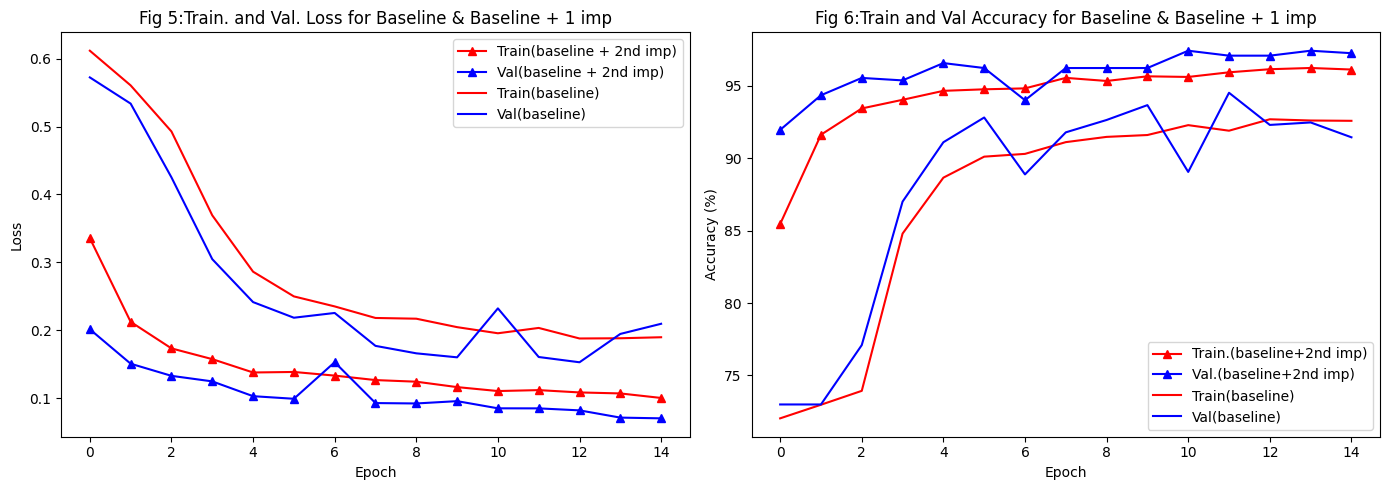

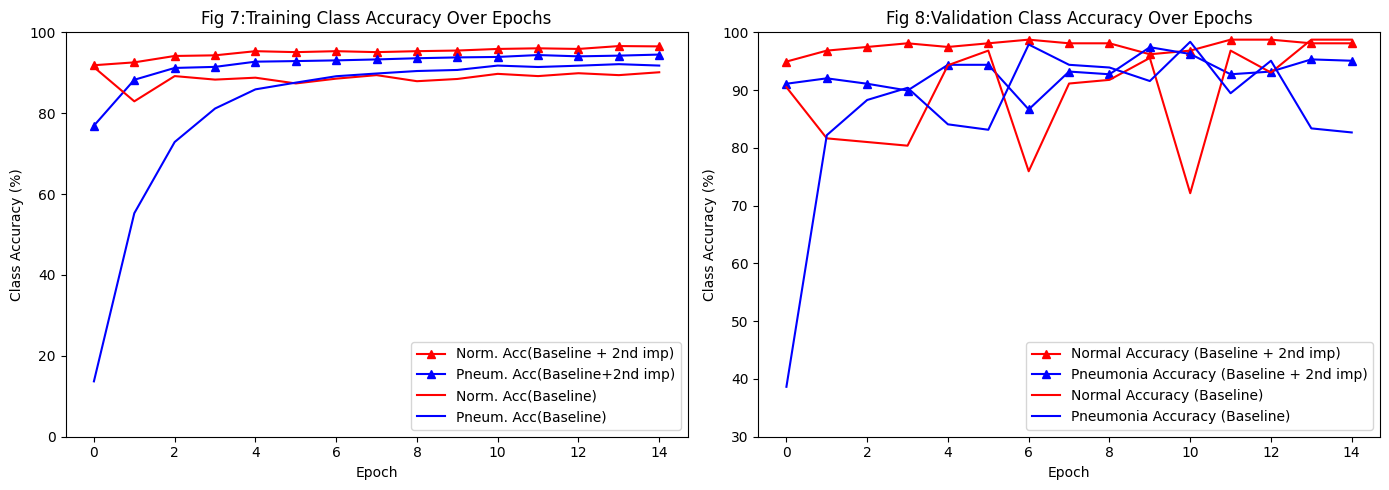

In [59]:
# train_losses_imp2, train_accuracies_imp, val_losses_imp, val_accuracies_imp, train_class_accuracies_imp, val_class_accuracies_imp
# train_losses_SimpleModel, train_accuracies_SimpleModel, val_losses_SimpleModel, val_accuracies_SimpleModel, train_class_accuracies_SimpleModel, val_class_accuracies_SimpleModel
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_imp2, label='Train(baseline + 2nd imp)', marker='^', linestyle='-',color='Red')
plt.plot(val_losses_imp2, label='Val(baseline + 2nd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_losses_SimpleModel, label='Train(baseline)', linestyle='-',color='Red')
plt.plot(val_losses_SimpleModel, label='Val(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fig 5:Train. and Val. Loss for Baseline & Baseline + 1 imp')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_imp2, label='Train.(baseline+2nd imp)',marker='^', linestyle='-',color='Red')
plt.plot(val_accuracies_imp2, label='Val.(baseline+2nd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_accuracies_SimpleModel, label='Train(baseline)', linestyle='-',color='Red')
plt.plot(val_accuracies_SimpleModel, label='Val(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Fig 6:Train and Val Accuracy for Baseline & Baseline + 1 imp')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 5))

# Extract values for each class from training and validation accuracies
train_class1_accuracies4 = [acc[0] for acc in train_class_accuracies_imp2]  # Class 1 in training
train_class2_accuracies4 = [acc[1] for acc in train_class_accuracies_imp2]  # Class 2 in training

val_class1_accuracies4 = [acc[0] for acc in val_class_accuracies_imp2]      # Class 1 in validation
val_class2_accuracies4 = [acc[1] for acc in val_class_accuracies_imp2]      # Class 2 in validation

train_class1_accuracies2= [acc[0] for acc in train_class_accuracies_SimpleModel]  # Class 1 in training
train_class2_accuracies2 = [acc[1] for acc in train_class_accuracies_SimpleModel]  # Class 2 in training

val_class1_accuracies2 = [acc[0] for acc in val_class_accuracies_SimpleModel]      # Class 1 in validation
val_class2_accuracies2 = [acc[1] for acc in val_class_accuracies_SimpleModel]      # Class 2 in validation

# Training Class Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_class1_accuracies4, label='Norm. Acc(Baseline + 2nd imp)', marker='^', linestyle='-',color='Red')
plt.plot(train_class2_accuracies4, label='Pneum. Acc(Baseline+2nd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_class1_accuracies2, label='Norm. Acc(Baseline)', linestyle='-',color='Red')
plt.plot(train_class2_accuracies2, label='Pneum. Acc(Baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Fig 7:Training Class Accuracy Over Epochs')
plt.ylim(0, 100)  # Set the y-axis range
plt.legend()

# Validation Class Accuracy Plot
plt.subplot(1, 2, 2)

plt.plot(val_class1_accuracies4, label='Normal Accuracy (Baseline + 2nd imp)', marker='^', linestyle='-',color='Red')
plt.plot(val_class2_accuracies4, label='Pneumonia Accuracy (Baseline + 2nd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(val_class1_accuracies2, label='Normal Accuracy (Baseline)', linestyle='-',color='Red')
plt.plot(val_class2_accuracies2, label='Pneumonia Accuracy (Baseline)', linestyle='-',color='Blue')

plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Fig 8:Validation Class Accuracy Over Epochs')
plt.ylim(30, 100)  # Set the y-axis range

plt.legend()


plt.tight_layout()
plt.show()

**(c)**

_Discuss your results here_


##**I HAVE CHOSEN THE SECOND OPTION OF SHOWING ONE INDIVIDUAL IMPROVEMENT ON THE BASELINE MODEL(This is IMPROVED CNN MODEL with batch normalisation and dropout with the baseline model**)

##Figure one and two shows the expected validation and training accuracies and losses from a good performing model. the validation loss and accuracies have a lower fluctions than the data augmentation + baseline model discussed previously, suggesting, the imporvement of this CNN model played a significant role in improving the performance of the final improved model.

##Figure 5 and 6
##The second improved model (red line) showed a somewhat smoother and a more consistent decline in both the training and validation losses, this indicates that the model benefitsThe dropout helps prevent overfitting by randomly deactivating neurons during training, and batch normalization stabilizes learning by normalizing inputs to each layer, thus helping the loss converge smoothly.

##Fig 6: The improved model achieves high training and validation accuracy without significant overfitting. This is likely the result of regularization effects of dropout, which prevent the model from memorizing training data, and batch normalization, which helps with generalization.

##Fig 7 and 8, the improved models lines are more stable and fluctuate less compared to the baselines lines, suggesting that the addition of this addional layers CNN with batch normalisation and dropout has significantly improved the performace of the model.

## Empirically justify improvement 3

Epoch [1/10], Train Loss: 0.5951, Train Acc: 72.76%, Val Loss: 0.5776, Val Acc: 72.99%


Epoch [2/10], Train Loss: 0.5736, Train Acc: 72.97%, Val Loss: 0.5629, Val Acc: 72.99%


Epoch [3/10], Train Loss: 0.5501, Train Acc: 72.97%, Val Loss: 0.5269, Val Acc: 72.99%


Epoch [4/10], Train Loss: 0.4941, Train Acc: 73.68%, Val Loss: 0.4409, Val Acc: 77.78%


Epoch [5/10], Train Loss: 0.3917, Train Acc: 82.77%, Val Loss: 0.3245, Val Acc: 87.69%


Epoch [6/10], Train Loss: 0.3010, Train Acc: 88.71%, Val Loss: 0.2727, Val Acc: 87.52%


Epoch [7/10], Train Loss: 0.2554, Train Acc: 89.69%, Val Loss: 0.2150, Val Acc: 91.11%


Epoch [8/10], Train Loss: 0.2302, Train Acc: 90.58%, Val Loss: 0.1920, Val Acc: 91.97%


Epoch [9/10], Train Loss: 0.2171, Train Acc: 91.44%, Val Loss: 0.1897, Val Acc: 93.33%


Epoch [10/10], Train Loss: 0.2099, Train Acc: 91.52%, Val Loss: 0.1682, Val Acc: 92.82%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▁▁▁▅▇▇███
Train Loss,██▇▆▄▃▂▁▁▁
Training Class Accuracy/Normal,▁▂█▇▇▅▆▇▆▆
Training Class Accuracy/Pneumonia,▁▁▂▃▅▇▇███
Validation Accuracy,▁▁▁▃▆▆▇███
Validation Class Accuracy/Normal,▂▇█▆▆▁▆▆██
Validation Class Accuracy/Pneumonia,▂▁▁▃▆█▇▇▇█
Validation Loss,██▇▆▄▃▂▁▁▁
Epoch,10


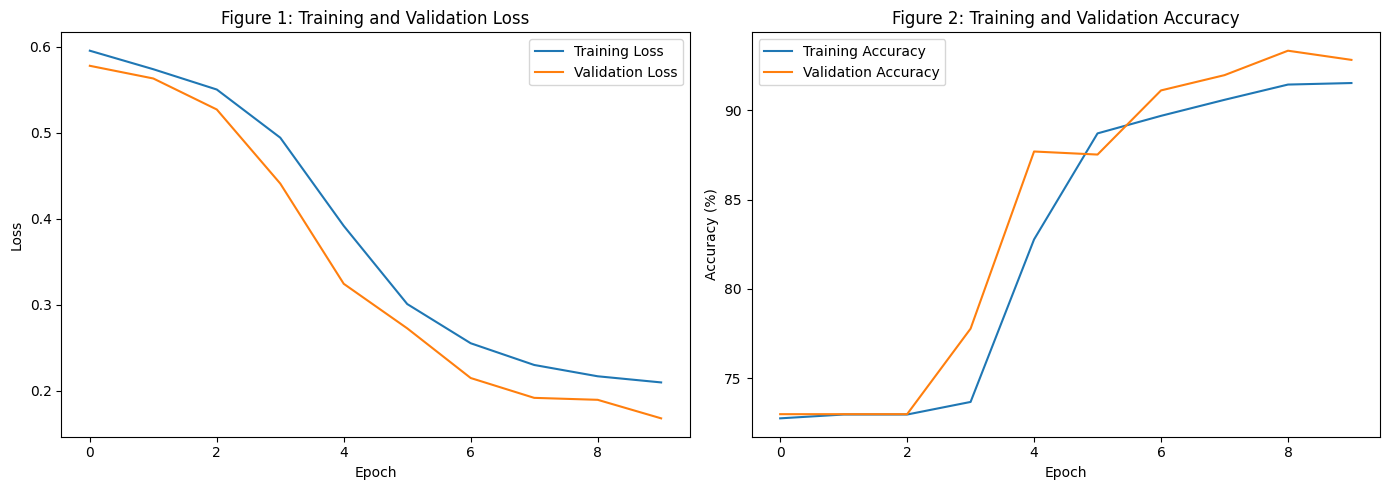

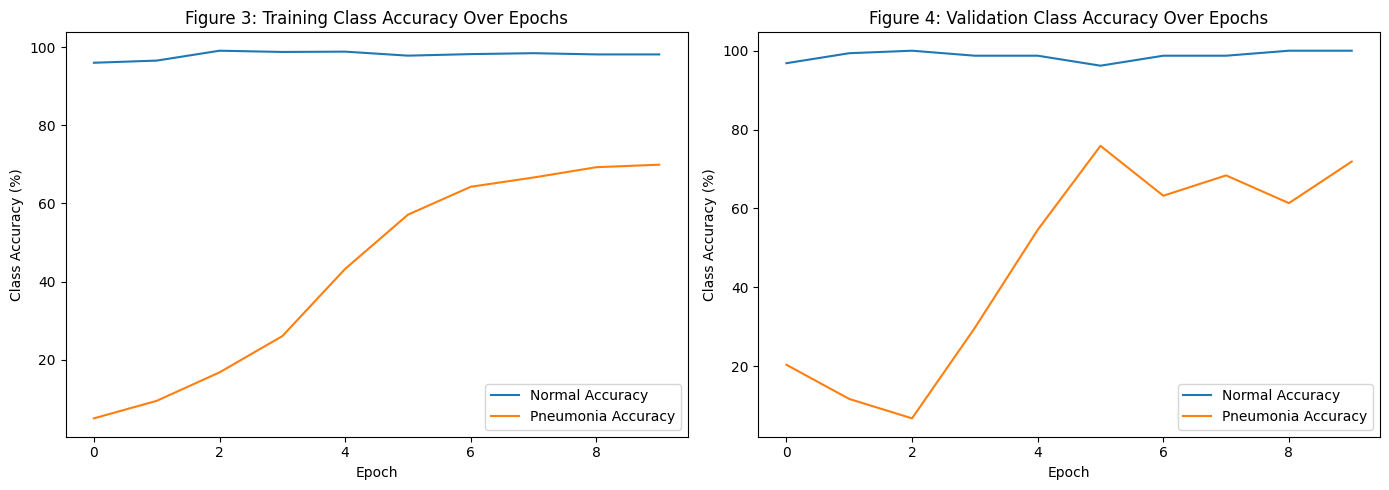

Model saved as 'chest_xray_model.pth'


In [25]:
# Implement the experiment in as many cells as you need.

# Initialize the model
model_imp3 = SimpleModel().to(device)

# Define loss function and optimizer

criterion_imp3 = nn.CrossEntropyLoss()

optimizer_imp3 = torch.optim.SGD(model_imp3.parameters(), lr=lr)

num_epochs=10
# Train the model
train_losses_imp3, train_accuracies_imp3, val_losses_imp3, val_accuracies_imp3, train_class_accuracies_imp3, val_class_accuracies_imp3 = train_model(
    model_imp3, train_loader_SimpleModel, val_loader_SimpleModel, criterion_imp3, optimizer_imp3, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses_imp3, train_accuracies_imp3, val_losses_imp3, val_accuracies_imp3, train_class_accuracies_imp3, val_class_accuracies_imp3)

# Save the model
torch.save(model_imp3.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

**(a)**

_State the improvement you are justifying_

##Early stopping(reduing the eopches to 10)

**(b)**

_Present your results, including plots etc, here_

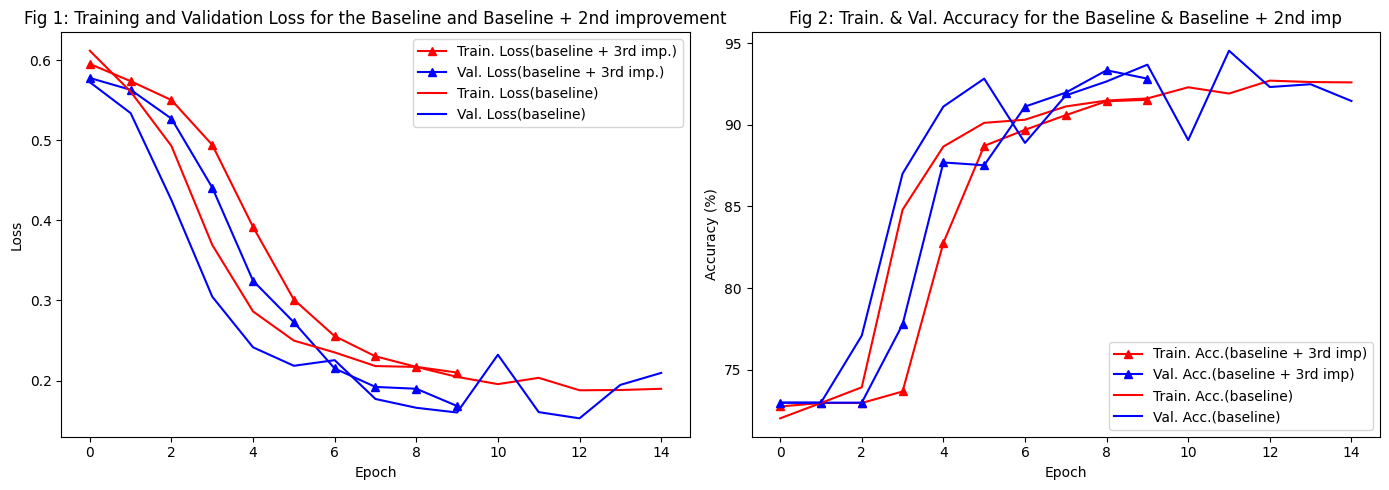

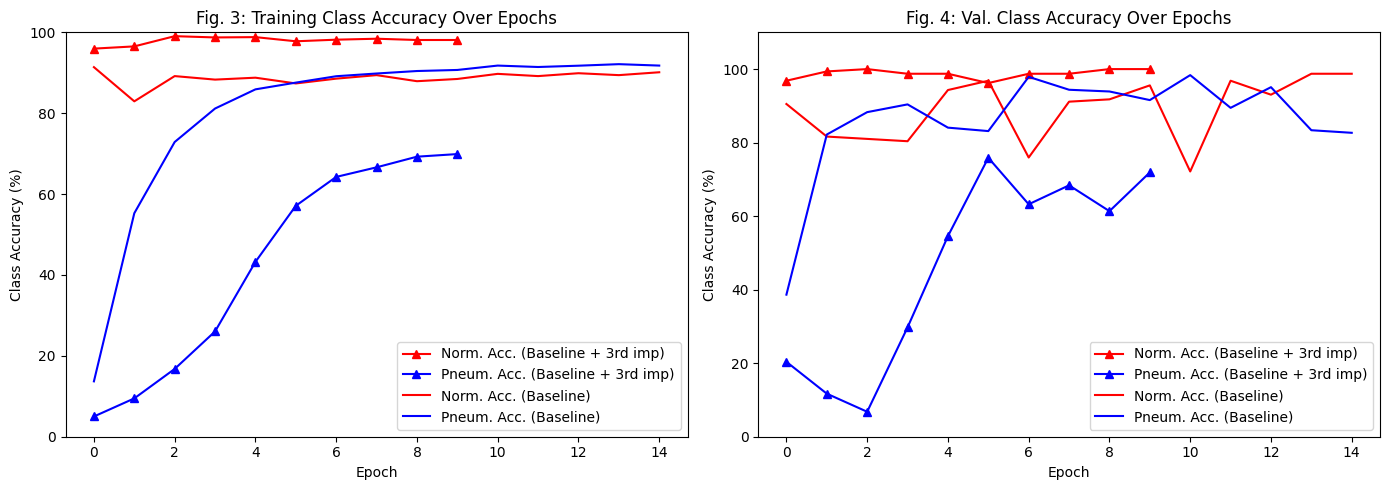

In [52]:
train_losses_imp3, train_accuracies_imp, val_losses_imp, val_accuracies_imp, train_class_accuracies_imp, val_class_accuracies_imp
train_losses_SimpleModel, train_accuracies_SimpleModel, val_losses_SimpleModel, val_accuracies_SimpleModel, train_class_accuracies_SimpleModel, val_class_accuracies_SimpleModel
# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_imp3, label='Train. Loss(baseline + 3rd imp.)', marker='^', linestyle='-',color='Red')
plt.plot(val_losses_imp3, label='Val. Loss(baseline + 3rd imp.)', marker='^', linestyle='-',color='Blue')
plt.plot(train_losses_SimpleModel, label='Train. Loss(baseline)', linestyle='-',color='Red')
plt.plot(val_losses_SimpleModel, label='Val. Loss(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fig 1: Training and Validation Loss for the Baseline and Baseline + 2nd improvement')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_imp3, label='Train. Acc.(baseline + 3rd imp)',marker='^', linestyle='-',color='Red')
plt.plot(val_accuracies_imp3, label='Val. Acc.(baseline + 3rd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_accuracies_SimpleModel, label='Train. Acc.(baseline)', linestyle='-',color='Red')
plt.plot(val_accuracies_SimpleModel, label='Val. Acc.(baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Fig 2: Train. & Val. Accuracy for the Baseline & Baseline + 2nd imp')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 5))

# Extract values for each class from training and validation accuracies
train_class1_accuracies5 = [acc[0] for acc in train_class_accuracies_imp3]  # Class 1 in training
train_class2_accuracies5 = [acc[1] for acc in train_class_accuracies_imp3]  # Class 2 in training

val_class1_accuracies5 = [acc[0] for acc in val_class_accuracies_imp3]      # Class 1 in validation
val_class2_accuracies5 = [acc[1] for acc in val_class_accuracies_imp3]      # Class 2 in validation

train_class1_accuracies2= [acc[0] for acc in train_class_accuracies_SimpleModel]  # Class 1 in training
train_class2_accuracies2 = [acc[1] for acc in train_class_accuracies_SimpleModel]  # Class 2 in training

val_class1_accuracies2 = [acc[0] for acc in val_class_accuracies_SimpleModel]      # Class 1 in validation
val_class2_accuracies2 = [acc[1] for acc in val_class_accuracies_SimpleModel]      # Class 2 in validation

# Training Class Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_class1_accuracies5, label='Norm. Acc. (Baseline + 3rd imp)', marker='^', linestyle='-',color='Red')
plt.plot(train_class2_accuracies5, label='Pneum. Acc. (Baseline + 3rd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(train_class1_accuracies2, label='Norm. Acc. (Baseline)', linestyle='-',color='Red')
plt.plot(train_class2_accuracies2, label='Pneum. Acc. (Baseline)', linestyle='-',color='Blue')
plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Fig. 3: Training Class Accuracy Over Epochs')
plt.ylim(0, 100)  # Set the y-axis range

plt.legend()

# Validation Class Accuracy Plot
plt.subplot(1, 2, 2)

plt.plot(val_class1_accuracies5, label='Norm. Acc. (Baseline + 3rd imp)', marker='^', linestyle='-',color='Red')
plt.plot(val_class2_accuracies5, label='Pneum. Acc. (Baseline + 3rd imp)', marker='^', linestyle='-',color='Blue')
plt.plot(val_class1_accuracies2, label='Norm. Acc. (Baseline)', linestyle='-',color='Red')
plt.plot(val_class2_accuracies2, label='Pneum. Acc. (Baseline)', linestyle='-',color='Blue')

plt.xlabel('Epoch')
plt.ylabel('Class Accuracy (%)')
plt.title('Fig. 4: Val. Class Accuracy Over Epochs')
plt.ylim(0, 110)  # Set the y-axis range

plt.legend()

plt.tight_layout()
plt.show()

**(c)**

_Discuss your results here_


##The graph above shows the two runs of the baseline model, with one having total epoches of 15 and the other having 10.

##The improvement of reducing epoches may somewhat look less effective compared to the other improvement that i have just discussed, however for my fully improvement model(i.e model with data augmentation, improved CNN ) leads to a quicker convergence where the training validation accuracies and losses become stagnant and plateau after converging quickly, this was not the case for the baseline model(with no improvements).

##Even though the baseline model showed more fluctuations than the improved model, the training and validation losses and accuracies would change more than that ones in the improved model, more specifically, the improvement model plateaus quite early compared to the baseline and doesn't improve for nearly half of the epoches, this could cause a problem since continuing to train after the model has already plateaued may lead to overfitting, where the model starts to memorize the training data instead of learning generalizable patterns. This unnecessary training could reduce the models performance on unseen data.

##The stagnation and plateauing of the accuracies and losses of the fully improved model can be seen in Fig1,2,3,4 in question 4.1 above(fully improved model section)

# Final Evaluation 



Testing: 100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Test Loss: 0.2588, Test Accuracy: 89.95%
Test Class Accuracy (Normal): 93.71%
Test Class Accuracy (Pneumonia): 88.55%


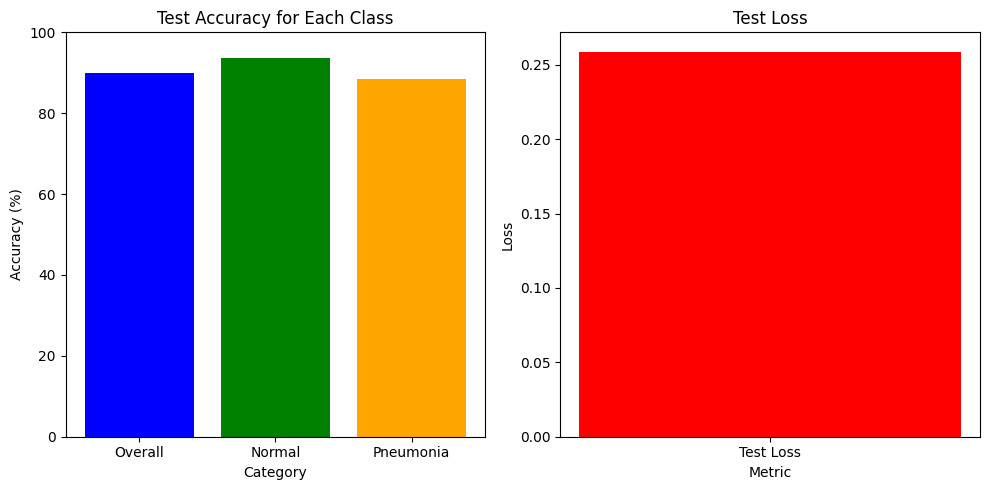

Testing: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Test Loss: 0.1850, Test Accuracy: 93.87%
Test Class Accuracy (Normal): 83.02%
Test Class Accuracy (Pneumonia): 97.90%


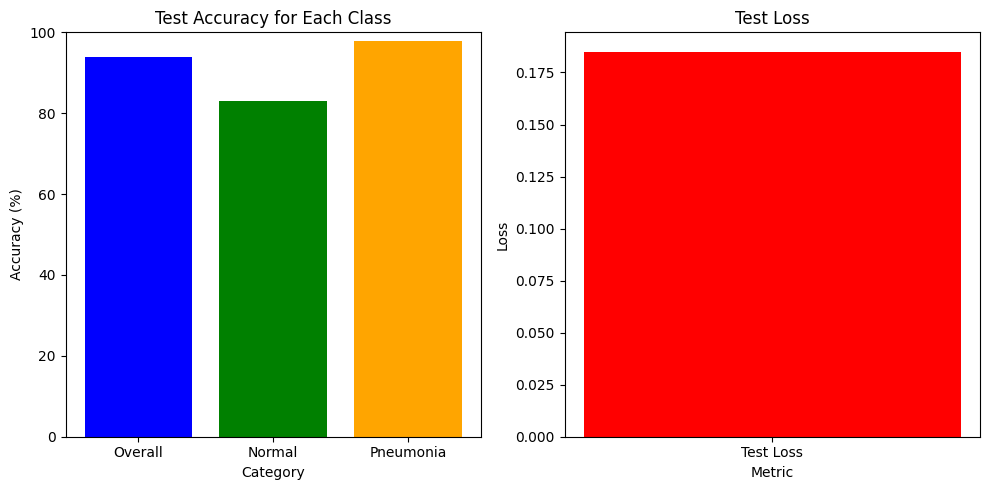

In [57]:

# Define a function to test the model
def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0
    class_correct = [0, 0]  # Correct predictions for each class
    class_total = [0, 0]  # Total samples for each class

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Get model predictions

            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)  # Accumulate loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)

            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            # Class-specific accuracy
            for i in range(len(labels)):
                label = int(labels[i].item())
                pred = int(predicted[i].item())
                if pred == label:
                    class_correct[label] += 1
                class_total[label] += 1


    # Calculate overall test accuracy and loss
    test_loss /= total_preds
    test_accuracy = (correct_preds / total_preds) * 100

    # Calculate per-class accuracy
    class_accuracies = [(class_correct[i] / class_total[i]) * 100 if class_total[i] > 0 else 0 for i in range(2)]

    # Print the results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Class Accuracy (Normal): {class_accuracies[0]:.2f}%")
    print(f"Test Class Accuracy (Pneumonia): {class_accuracies[1]:.2f}%")

    return test_loss, test_accuracy, class_accuracies



# Define loss function and optimizer
# Run the test function
import matplotlib.pyplot as plt

# Assuming test_accuracy and test_class_accuracies are obtained from the test_model function

def plot_test_results(test_accuracy, test_class_accuracies, test_loss):
    # Bar plot for overall and per-class accuracy
    plt.figure(figsize=(10, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    labels = ['Overall', 'Normal', 'Pneumonia']
    accuracies = [test_accuracy, test_class_accuracies[0], test_class_accuracies[1]]
    plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
    plt.ylim(0, 100)
    plt.xlabel('Category')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy for Each Class')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.bar(['Test Loss'], [test_loss], color='red')
    plt.xlabel('Metric')
    plt.ylabel('Loss')
    plt.title('Test Loss')

    plt.tight_layout()
    plt.show()

test_loss_SimpleModel, test_accuracy_SimpleModel, test_class_accuracies_SimpleModel = test_model(model_SimpleModel, test_loader_SimpleModel, criterion_SimpleModel, device)
# Call the function to plot the results
plot_test_results(test_accuracy_SimpleModel, test_class_accuracies_SimpleModel, test_loss_SimpleModel)


test_loss_imp, test_accuracy_imp, test_class_accuracies_imp = test_model(model_imp, test_loader_imp, criterion_imp, device)
# Call the function to plot the results
plot_test_results(test_accuracy_imp, test_class_accuracies_imp, test_loss_imp)



**(a)**

_Present your results, including plots etc, here_

The results are displayed above.

**(b)**

_Discuss your results here_

##The results show that the test accuracy of the baseline + 3 improved model is 93.87, and the baseline modle accuracy is 89.55 percent, which shows an improvement, which suggests that my 3 improvements of Data augmentation, improved CNN with batch normalisation and dropout and the early stopping has improved my models performance.

##For normal scans, the baseline model has a test accuracy of 93.71% while the improved model has a lower accuracy for this class at 83.02%. This drop could indicate that the improved model, while better overall, may have overemphasized patterns relevant to detecting pneumonia, possibly due to the increased focus on capturing more complex features. Furthermore, the class imbalance of majority of scans being of pneumonia could have played a part, hence oversampling or using weights could further improve this model,

##For Pneumonia scans, the baseline model has a test accuracy of 88.55% while the improved model shows a significant increase to 97.90%. this is a very significant gap suggesting that the model has benefited from increasing the complexity of CNN model and the regularistiaon techniques used.

##The test loss for the baseline model is 0.2588, whereas for the improved model, its reduced to 0.1850. A lower test loss further proove the three modifications that were made have contributed to better generalization, as it indicates that the predictions are closer to the true labels, especially for the pneumonia class.